# Compsci 753 A2 
Joshua Monigatti <br>
jmon587 <br>
677195382 <br>

In [1]:
### Imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r 
import seaborn as sns
import math
from statistics import median
from time import time 
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
# Importing Data set 
data = pd.read_json('challenge_set.json')["playlists"]

# Part 1 Brute Force Approach

In [3]:
def bruteforce(data):
    counts = {}
    total_frequencies = 0 
    track_dic = {}
    
    for row in data: 
        row = row['tracks']
        if len(row) > 0: 
            try:
                for i in range(len(row)):
                    key = row[i]['track_uri']
                    total_frequencies += 1
                    if key in counts.keys(): 
                        counts[key] += 1 
                    else: 
                        counts[key] = 1 
                        track_dic[key] = row[i]['track_name']
            except: # Just in case an error occurs
                continue
    return {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse = True)}, len(counts.keys()), total_frequencies, track_dic

In [4]:
# Results of bruteforce 
brute_frequency, uniques, total_frequencies, track_dic = bruteforce(data)

# Sanity Check

In [5]:
sum([x for x in brute_frequency.values()])

281000

In [6]:
# Part 1a) 
print(f"Total number of tracks: {total_frequencies}")
print(f"Total number of unique Tracks: {uniques}")
print(f"The average frequency of the tracks/songs in the data stream: {total_frequencies/uniques:.2f}")

Total number of tracks: 281000
Total number of unique Tracks: 66243
The average frequency of the tracks/songs in the data stream: 4.24


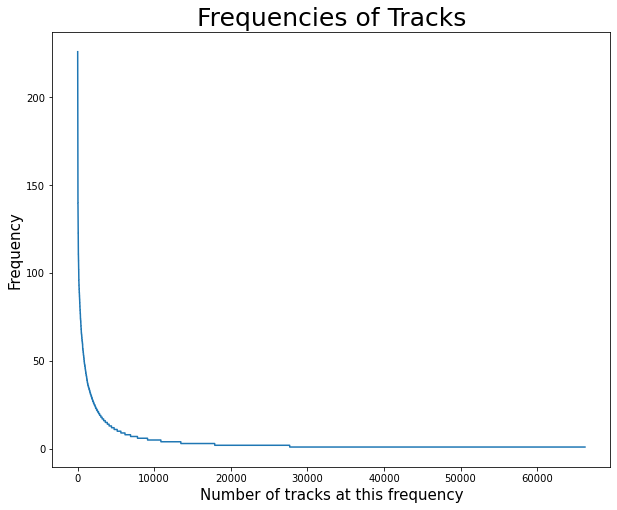

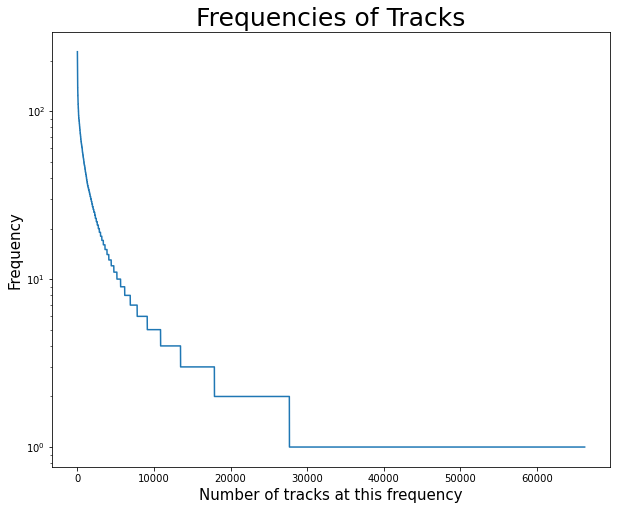

In [7]:
# Part 1b) 
b_freq = pd.DataFrame(list(zip(brute_frequency.keys(), brute_frequency.values())), columns = ['track_uri', 'Frequency'])
plot = sns.lineplot(data = b_freq, legend = None)
size = 15
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title("Frequencies of Tracks", fontsize = size + 10)
plt.show()
plot = sns.lineplot(data = b_freq, legend = None)
size = 15
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title("Frequencies of Tracks", fontsize = size + 10)
plt.yscale('log')
plt.show()

# Part 2 Mirsa-Gries Approach

In [8]:
# Part iia) 
def decremental_step(res): 
    # Subtract 1 from all of the frequencies
    shallow_copy = res.copy() # Fun error if its not a copy
    for track, value in shallow_copy.items(): 
        if value - 1 <= 0: # If frequency is 0, delete the track
            del res[track]
        else: 
            res[track] -= 1 # if not them simply decrease the count
            
def misra_gries(data, k): 
    res = {}
    dec_steps = 0 
    for row in data: 
        row = row['tracks']
        if len(row) > 0: 
            try:
                for i in range(len(row)):
                    key = row[i]['track_uri']
                    if key in res.keys(): # If track is in S then update frequency
                        res[key] += 1 
                        
                    elif len(res) < k: # If track not in S and still room to add, then add 
                        res[key] = 1 
                        
                    else: 
                        dec_steps += 1
                        decremental_step(res) # If S is full then decrease all by 1
                         
            except Exception as e: 
                print(e)
                continue
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse = True)}, dec_steps

In [9]:
K = 10000 # Max records in Summary
mirsa_frequencies, dec_steps = misra_gries(data, K)

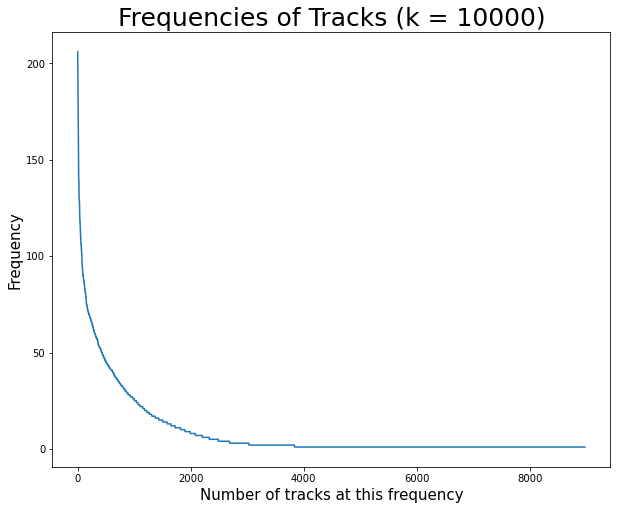

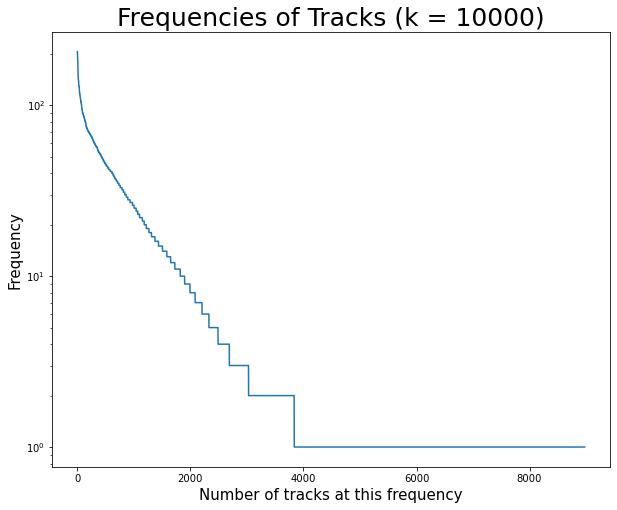

Number of unique tracks in summary on the final iteration: 8976
Number of tracks in summary on the final iteration: 80980
Percentage of unique tracks kept: 0.14%
Percentage of tracks kept: 0.29%


In [10]:
mg_freq = pd.DataFrame(list(zip(mirsa_frequencies.keys(), mirsa_frequencies.values())), columns = ['track_uri', 'Frequency'])
plot = sns.lineplot(data = mg_freq, legend = None)
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title(f"Frequencies of Tracks (k = {K})", fontsize = size + 10)
plt.show()
plot = sns.lineplot(data = mg_freq, legend = None)
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title(f"Frequencies of Tracks (k = {K})", fontsize = size + 10)
plt.yscale('log')
plt.show()
print(f"Number of unique tracks in summary on the final iteration: {len(mirsa_frequencies.keys())}")
print(f"Number of tracks in summary on the final iteration: {sum(mirsa_frequencies.values())}")
print(f"Percentage of unique tracks kept: {len(mirsa_frequencies.keys()) / uniques:.2f}%")
print(f"Percentage of tracks kept: {sum(mirsa_frequencies.values()) / total_frequencies:.2f}%")

In [11]:
# Part 2c)
def mirsa_20_re(mirsa_frequencies, brute_frequency):
    # Collecting the top 20 tracks from Misra-Gries run
    mirsa_re = []
    i = 0 
    for key, val in mirsa_frequencies.items(): 
        if i == 20: 
            break 
        mirsa_re.append(abs(1 - val / brute_frequency[key]))
        i += 1
    return mirsa_re

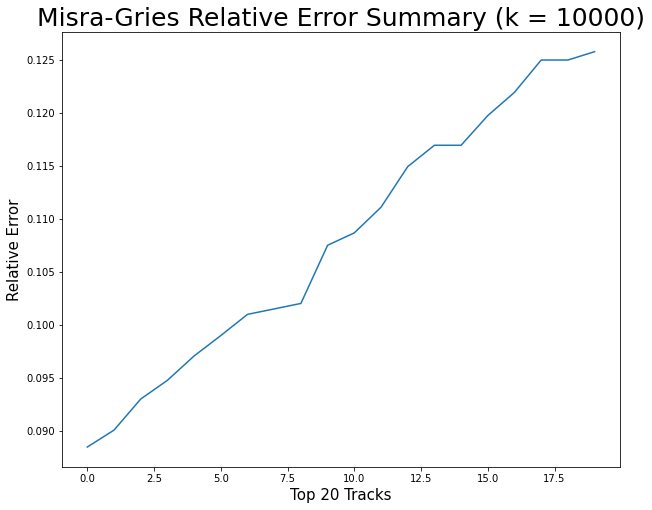

Value of k: 10000
Number of decremental steps with given k: 20


In [12]:
# Plotting the results 
mirsa_re = mirsa_20_re(mirsa_frequencies, brute_frequency)
plt.plot(mirsa_re)
size = 15
plt.title(f"Misra-Gries Relative Error Summary (k = {K})", fontsize = size + 10)
plt.xlabel("Top 20 Tracks", fontsize = size)
plt.ylabel("Relative Error", fontsize = size)
plt.show()

print(f"Value of k: {K}")
print(f"Number of decremental steps with given k: {dec_steps}")

# Part 3 <br> Count Sketch Approach and Performance Evaluation

In [125]:
# Part 3a) 
def universal_hash(d, p): 
    return [(r.randint(1, p - 1), r.randint(0, p - 1)) for _ in range(d)]

def sign_hash(d, p): 
    return [(r.randint(1, p - 1), r.randint(0, p - 1)) for _ in range(d)]

def create_buckets(w, d): 
    return [{k:0 for k in range(w)} for _ in range(d)]

def display_filled_buckets(cs): 
    for line in cs: 
        print(line)
        print()
    
def track_x_values(ids): 
    return {k : i for i, k in enumerate(ids.keys())}

# Inserting the elements into the counter lists using Count Sketch
def count_sketch(data, ids, w, d, p): 
    res = create_buckets(w, d)
    u_hash = universal_hash(d, p)
    s_hash = sign_hash(d, p)
    for row in data: 
        row = row['tracks']
        if len(row) > 0: 
            try:
                for i in range(len(row)):
                    # Convert the track_uri into unicode value so it can be hashed
                    x = ids[row[i]['track_uri']]
                        
                    # Hash into each bucket and work out the sign that will used 
                    for i in range(d): 
                        loc = ((u_hash[i][0] * x + u_hash[i][1]) % p) % w
                        if ((s_hash[i][0] * x + s_hash[i][1]) % p) % 2 == 0: 
                            res[i][loc] += 1
                        else: res[i][loc] -= 1
    
            except Exception as e: 
                print(e)
                continue
    return res, u_hash, s_hash

def count_freq(track_dic, ids, cs, u_hash, s_hash, p, w):
    res = {}
    for track_uri in track_dic.keys():
        x = ids[track_uri] # Get the x val
        col_vals = [] # Collision Values
        for i, hash_function in enumerate(u_hash):
            # Go through each bucket and pull out the value at the col
            loc = ((hash_function[0] * x + hash_function[1]) % p) % w
            if ((s_hash[i][0] * x + s_hash[i][1]) % p) % 2 == 0: # This flip was listed on piazza by Meng-Fen
                col_vals.append(cs[i][loc] * 1)  
            else: 
                col_vals.append(cs[i][loc] * -1)
        
        # Take the median of the values 
        col_vals.sort()
        
        res[track_uri] = median(col_vals)

    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse = True)}

In [14]:
# Static Variables
ep = 0.01 # Number of miscounts allowed 
delta = 0.01 # Demanded Success rate

p = 328243
w = math.ceil(2 / (ep ** 2)) # Calculating the required w
d = math.ceil(math.log(1 / delta, 2)) # Calculating the required d
ids = track_x_values(brute_frequency)

In [15]:
cs, u_hash, s_hash = count_sketch(data, ids, w, d, p)
cq = count_freq(track_dic, ids, cs, u_hash, s_hash, p, w)

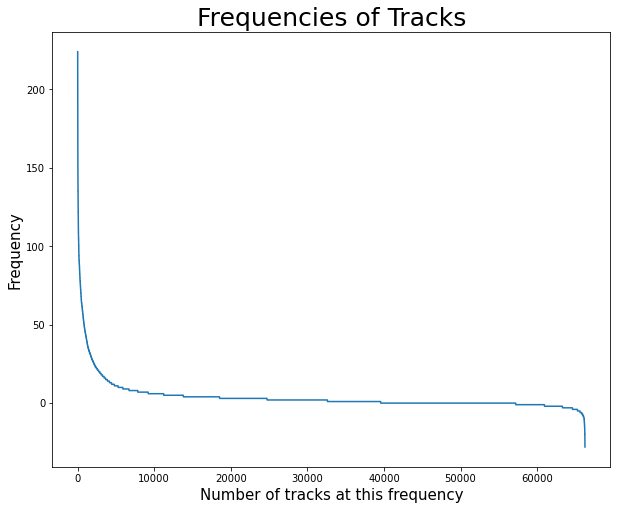

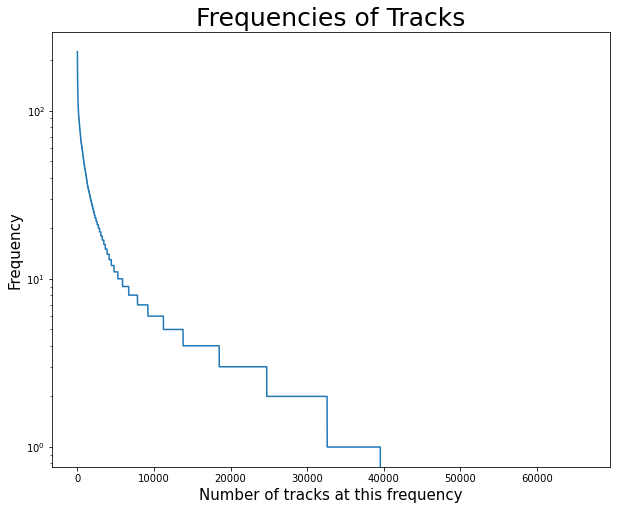

Choosen Epsilon: 0.01
Choosen Delta: 0.01
Resulting w: 20000
Resulting d: 7
Dimensions of count matrix: 20000 x 7 (140000)


In [28]:
c_freq = pd.DataFrame(list(zip(cq.keys(), cq.values())), columns = ['track_uri', 'Frequency'])
plot = sns.lineplot(data = c_freq, legend = None)
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title("Frequencies of Tracks", fontsize = size + 10)
plt.show()
plot = sns.lineplot(data = c_freq, legend = None)
plt.xlabel("Number of tracks at this frequency", fontsize = size)
plt.ylabel("Frequency", fontsize = size)
plt.title("Frequencies of Tracks", fontsize = size + 10)
plt.yscale('log')
plt.show()
print(f"Chosen Epsilon: {ep}")
print(f"Chosen Delta: {delta}")
print(f"Resulting w: {w}")
print(f"Resulting d: {d}")
print(f"Dimensions of count matrix: {w} x {d} ({w*d})")

In [17]:
# Part 3b) Calculating the relative error for Count Sketch 
def count_sketch_re(cq, brute_frequency):
    re_count = []
    for key, val in cq.items(): 
        re_count.append(abs(1 - val / brute_frequency[key]))
    return re_count

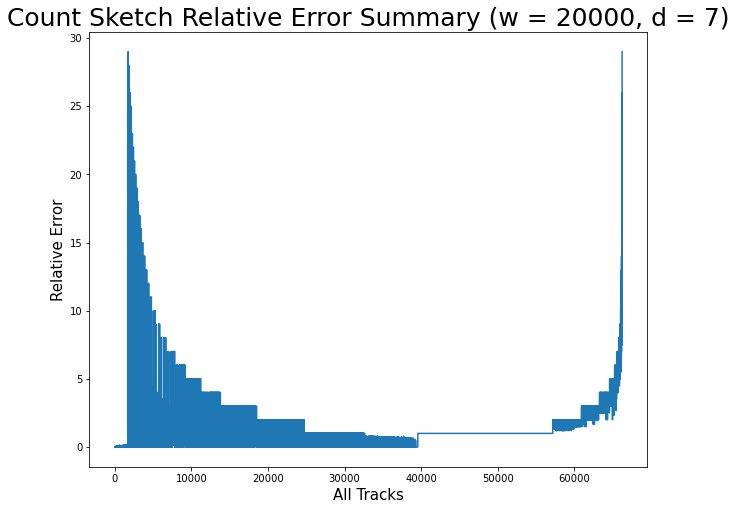

In [30]:
sketch_re = count_sketch_re(cq, brute_frequency)
plt.plot(sketch_re)
plt.title(f"Count Sketch Relative Error Summary (w = {w}, d = {d})", fontsize = size + 10)
plt.xlabel("All Tracks", fontsize = size)
plt.ylabel("Relative Error", fontsize = size)
plt.show()

In [154]:
def re_all_mirsa(k_re, observerd, truth): 
    k_re.append(abs(1 - (1 / len(truth.keys())) * sum([val / truth[key] for key, val in observerd.items()])))
    
def re_all_count(k_re, observerd, truth): 
    k_re.append(abs(1 - (1 / len(truth.keys())) * sum([val / truth[key] for key, val in observerd.items()])))

In [159]:
# Part 3c) 
k_vals = [500, 1000, 1500, 2000, 2500, 3500, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 66243]
mirsa_var_k = []
mirsa_run_time = []
misra_k_20 = []

fixed_d = 5
count_var_k = []
count_run_time = []
count_k_20 = []
for k in k_vals: 
    # Generating the Grisa-Gries Values 
    start = time()
    mirsa_k_frequencies, k_dec_steps = misra_gries(data, k)
    re_all_mirsa(mirsa_var_k, mirsa_k_frequencies, brute_frequency)
    mirsa_run_time.append(time() - start)
    misra_k_20.append(mirsa_20_re(mirsa_k_frequencies, brute_frequency))
    
    # Generating the Count Sketch Values
    start = time()
    local_w = k // fixed_d
    cs_local, u_hash, s_hash = count_sketch(data, ids, local_w, fixed_d, p)
    cq_local = count_freq(track_dic, ids, cs_local, u_hash, s_hash, p, local_w)
    re_all_count(count_var_k, cq_local, brute_frequency)
    count_run_time.append(time() - start)
    count_k_20.append(count_sketch_re(cq_local, brute_frequency))
    
    

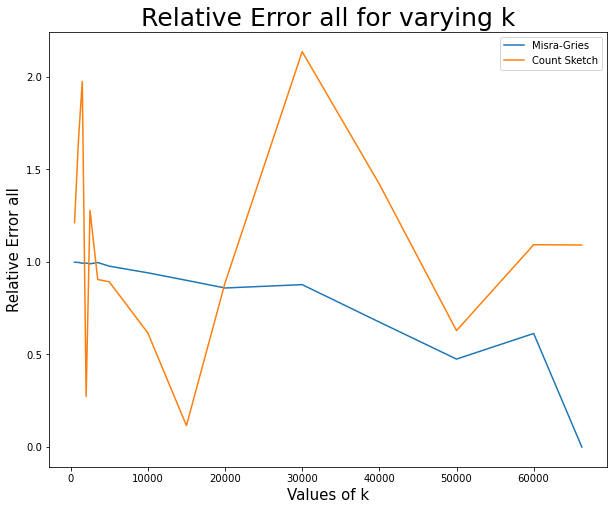

Values of k: [500, 1000, 1500, 2000, 2500, 3500, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 66243]


In [160]:
plt.plot(k_vals, mirsa_var_k, label = "Misra-Gries")
plt.plot(k_vals, count_var_k, label = "Count Sketch")
plt.title("Relative Error all for varying k", fontsize = size + 10)
plt.xlabel("Values of k", fontsize = size)
plt.ylabel("Relative Error all", fontsize = size)


plt.legend()
plt.show()
print(f"Values of k: {k_vals}")

In [161]:
print("=" * 30, "Mirsa-Gries run time", "=" * 30, sep = "\n")
for i, val in enumerate(mirsa_run_time): 
    print(f"Value of k: {k_vals[i]}, run time: {val:.2f}s")

print()
print("=" * 30, "Count Sketch run time", "=" * 30, sep = "\n")
for i, val in enumerate(count_run_time): 
    print(f"Value of k: {k_vals[i]}, run time: {val:.2f}s")

Mirsa-Gries run time
Value of k: 500, run time: 0.14s
Value of k: 1000, run time: 0.13s
Value of k: 1500, run time: 0.13s
Value of k: 2000, run time: 0.15s
Value of k: 2500, run time: 0.16s
Value of k: 3500, run time: 0.14s
Value of k: 5000, run time: 0.15s
Value of k: 10000, run time: 0.15s
Value of k: 15000, run time: 0.17s
Value of k: 20000, run time: 0.18s
Value of k: 30000, run time: 0.16s
Value of k: 40000, run time: 0.17s
Value of k: 50000, run time: 0.17s
Value of k: 60000, run time: 0.17s
Value of k: 66243, run time: 0.16s

Count Sketch run time
Value of k: 500, run time: 1.30s
Value of k: 1000, run time: 1.25s
Value of k: 1500, run time: 1.42s
Value of k: 2000, run time: 1.48s
Value of k: 2500, run time: 1.34s
Value of k: 3500, run time: 1.42s
Value of k: 5000, run time: 1.43s
Value of k: 10000, run time: 1.38s
Value of k: 15000, run time: 1.35s
Value of k: 20000, run time: 1.46s
Value of k: 30000, run time: 1.57s
Value of k: 40000, run time: 1.46s
Value of k: 50000, run time

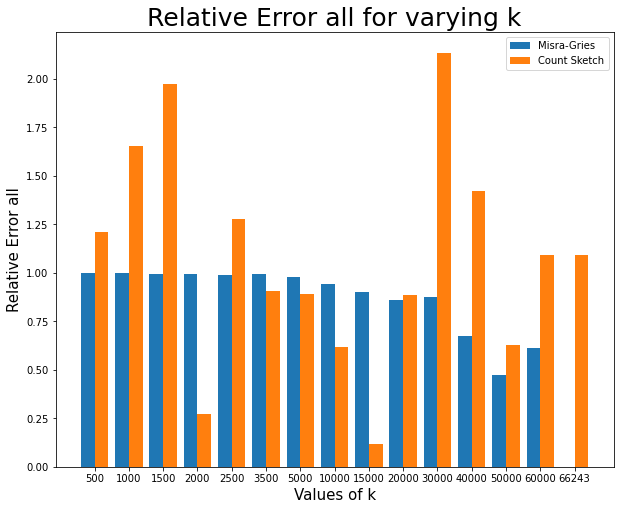

In [162]:
# Bar plot to more easily see the values
plt.title(f"Relative Error all for varying k", fontsize = size + 10)
plt.xlabel("Values of k", fontsize = size)
plt.ylabel("Relative Error all", fontsize = size)
X_axis = np.arange(len(k_vals))
plt.bar(X_axis - 0.2, mirsa_var_k, 0.4, label = "Misra-Gries")
plt.bar(X_axis + 0.2, count_var_k, 0.4, label = "Count Sketch")
plt.xticks(X_axis, k_vals)
plt.legend()
plt.show()

In [124]:
# Part 3d) 
# i) Track name
# ii) Estimated Frequency 
# iii) True Frequency
# iv) RE

i = j = 0 

print("=" * 30, f"Top 20 Tracks by Misra-Gries", f"k = {K}", "=" * 30, sep = "\n")
for key, val in mirsa_frequencies.items():
    if i == 20: 
        break
    #print(f"Track as unicode: {sum(ord(x) for x in track_dic[key])}")
    print(f"\n{'=' * 10} Rank {i + 1} {'=' * 10}")
    print(f"Track Name: {track_dic[key]}")
    print(f"Estimated Frequency: {val}")
    print(f"True Frequency: {brute_frequency[key]}")
    print(f"Relative Error for track: {mirsa_re[i]}")
    i += 1

print("\n")
print("=" * 30, "Top 20 Tracks by Count Sketch", f"Epsilon = {ep}, Delta = {delta}", "=" * 30, sep = "\n")
for key, val in cq.items():
    if j == 20: 
        break
    print(f"\n{'=' * 10} Rank {j + 1} {'=' * 10}")
    print(f"Track Name: {track_dic[key]}")
    print(f"Estimated Frequency: {val}")
    print(f"True Frequency: {brute_frequency[key]}")
    print(f"Relative Error for track: {sketch_re[j]}")
    j += 1


Top 20 Tracks by Misra-Gries
k = 10000

========== Rank 1 ==========
Track Name: Broccoli (feat. Lil Yachty)
Estimated Frequency: 206
True Frequency: 226
Relative Error for track: 0.08849557522123896

========== Rank 2 ==========
Track Name: Ignition - Remix
Estimated Frequency: 202
True Frequency: 222
Relative Error for track: 0.09009009009009006

========== Rank 3 ==========
Track Name: Gold Digger
Estimated Frequency: 195
True Frequency: 215
Relative Error for track: 0.09302325581395354

========== Rank 4 ==========
Track Name: No Role Modelz
Estimated Frequency: 191
True Frequency: 211
Relative Error for track: 0.09478672985781988

========== Rank 5 ==========
Track Name: Closer
Estimated Frequency: 186
True Frequency: 206
Relative Error for track: 0.09708737864077666

========== Rank 6 ==========
Track Name: HUMBLE.
Estimated Frequency: 182
True Frequency: 202
Relative Error for track: 0.09900990099009899

========== Rank 7 ==========
Track Name: Jumpman
Estimated Frequency: 178
T